# __Sistema de Recomendación de Productos para Comercios Locales__

## __Resumen y Contexto Comercial__:

**Mayorista11**, una distribuidora líder de productos, busca optimizar las recomendaciones que ofrece a los **comercios locales**. El objetivo es **impulsar las ventas** mediante un sistema de recomendación que sugiera productos que un comercio aún no ha comprado, priorizando aquellos que son populares en **comercios similares dentro de la misma comuna**.

La necesidad surge debido a que muchos comercios no aprovechan todo el potencial de su inventario, al no ofrecer ciertos productos que son populares en su área. Con un sistema de recomendación eficiente, Mayorista11 puede **mejorar la personalización de su oferta** y ayudar a los comercios a:

- **Aumentar sus ventas** al ofrecer productos que tienen demanda local.

- **Optimizar su inventario** evitando sugerencias de productos que ya han adquirido.

- **Fortalecer la relación comercial** al sugerir productos basados en datos relevantes, alineados con las necesidades locales.

El éxito de este proyecto proporcionaría a Mayorista11 una ventaja competitiva, ya que los comercios locales tendrían un **soporte basado en inteligencia de mercado**, mejorando la eficiencia de sus operaciones.

## 

### Descripción de las Bases de Datos y sus Características:

1. **`transactions.csv`**: Historial de compras realizadas por cada comercio.


     - `id_commerce`: ID único que identifica a cada comercio.

     - `id_product`: ID único que identifica a cada producto.

     - `quantity`: La cantidad comprada del producto en una transacción.

     - `price_x`: El precio total pagado por la cantidad comprada (precio unitario multiplicado por cantidad).


2. **`commerces.csv`**: Información sobre los comercios locales, incluyendo ubicación geográfica.


     - `id_commerce`: ID único que identifica a cada comercio.

     - `district`: La comuna o distrito en el que se encuentra ubicado el comercio.


3. **`products.csv`**: Información sobre los productos disponibles, incluyendo detalles como la categoría y el valor unitario.


     - `id_product`: ID único que identifica a cada producto.

     - `name`: Nombre del producto.

     - `category`: Categoría a la que pertenece el producto (por ejemplo, Alimentos, Electrónica, Ropa).
     
     - `price_y`: Precio unitario de cada producto.


### Relación entre las Tablas:

- La tabla de **transacciones** (`transactions.csv`) se relaciona con la tabla **comercios** (`commerces.csv`) a través de la columna `id_commerce`.

- La **tabla de transacciones** también se relaciona con la **tabla de productos** (`products.csv`) a través de la columna `id_product`.

La tablas se relacionan en formato estrella, `transacciónes` corresponde a la tabla de hechos y `comercios` y `productos` las tablas de dimesiones. Luego de combinar sus llaves primarias, podemos obtener información completa sobre qué productos compró cada comercio, en qué cantidad, y en qué comuna está ubicado dicho comercio.

![Diagrama Entidad Relación](diagrama_entidad_relacion.jpg)

## __Carga de Datos__

A continuación, se procederá a cargar los datos desde los archivos proporcionados. Se realizará lo siguiente para garantizar la calidad y consistencia de los datos:

1. Verificación de la estructura de cada tabla (filas y columnas).

2. Comprobación de registros duplicados.

3. Detección de valores nulos.

4. Exploración de valores únicos por categoría relevante para asegurar la integridad de los datos.

Este análisis preliminar es clave para detectar cualquier problema que pueda influir en el rendimiento del modelo y garantizar que los datos estén listos para las siguientes etapas de preprocesamiento y modelado.

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

### __Productos__

In [2]:
# Cargar datos y convertir a DataFrame
productos = pd.read_csv('product.csv')

# Mostrar primeras filas
productos.head()

,id_product,name,category,price
0,1,Producto 1,Hogar,54
1,2,Producto 2,Electrónica,76
2,3,Producto 3,Hogar,67
3,4,Producto 4,Alimentos,95
4,5,Producto 5,Ropa,95


In [3]:
# Estructura de los datos
productos.shape

(50, 4)

In [4]:
# Información de productos
productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_product  50 non-null     int64 
 1   name        50 non-null     object
 2   category    50 non-null     object
 3   price       50 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ KB


In [5]:
# Verificar si hay duplicados
productos.duplicated().sum()

0

In [6]:
# Cantidad de productos por categoría
productos['category'].value_counts()

category
Ropa           13
Hogar          10
Electrónica    10
Alimentos       9
Juguetes        8
Name: count, dtype: int64

Tras revisar la estructura y calidad de los datos del archivo `product.csv`, se observa que la tabla contiene 50 registros distribuidos en 4 columnas, sin valores nulos en ninguna de ellas.  "Ropa" es la categoría con mayor cantidad de productos (13) y "Juguetes" con menos (8). No se encontraron registros duplicados, lo que indica que los datos no presentan problemas de redundancia.

### __Comercios__

In [7]:
# Cargar datos y convertir a DataFrame
comercios = pd.read_csv('commerces.csv')
comercios.head()

,id_commerce,district
0,1,Providencia
1,2,Penalolen
2,3,Penalolen
3,4,Nunoa
4,5,Nunoa


In [8]:
# Estructura de los datos
comercios.shape

(100, 2)

In [9]:
# Información de comercios
comercios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_commerce  100 non-null    int64 
 1   district     100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [10]:
# Verificar si hay duplicados
comercios.duplicated().sum()

0

In [11]:
# Comercios por comuna
comercios['district'].value_counts()

district
Penalolen      26
Nunoa          21
Providencia    19
La Florida     19
Macul          15
Name: count, dtype: int64

La tabla `commerces.csv` contiene 100 registros y 2 columnas, sin valores nulos ni duplicados. La distribución de comercios por comuna es homogénea, con "Peñalolén" teniendo la mayor cantidad de comercios (26) y "Macul" la menor (15).

### __Transacciones__

In [12]:
transacciones = pd.read_csv('transactions.csv')
transacciones.head()

,id_commerce,id_product,quantity,price
0,27,17,6,324
1,64,50,7,693
2,49,5,4,380
3,58,22,4,168
4,9,33,7,343


In [13]:
transacciones.shape

(500000, 4)

In [14]:
transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   id_commerce  500000 non-null  int64
 1   id_product   500000 non-null  int64
 2   quantity     500000 non-null  int64
 3   price        500000 non-null  int64
dtypes: int64(4)
memory usage: 15.3 MB


In [15]:
transacciones.duplicated().sum()

455000

In [16]:
# Mostrar algunos duplicados
duplicated_rows = transacciones[transacciones.duplicated(keep=False)]
duplicated_rows.head(10)

,id_commerce,id_product,quantity,price
0,27,17,6,324
1,64,50,7,693
2,49,5,4,380
3,58,22,4,168
4,9,33,7,343
5,26,31,8,448
6,99,19,4,392
7,60,17,1,54
8,61,10,7,392
9,76,47,4,216


In [17]:
# Agrupar por id_commerce e id_product, sumando la cantidad comprada para consolidar las transacciones duplicadas
transactions_group = transacciones.groupby(['id_commerce', 'id_product']).agg({'quantity': 'sum', 'price': 'sum'}).reset_index()

# Mostrar las primeras filas de las transacciones agrupadas
transactions_group

,id_commerce,id_product,quantity,price
0,1,1,473,25542
1,1,2,624,47424
2,1,3,599,40133
3,1,4,482,45790
4,1,5,499,47405
...,...,...,...,...
4995,100,46,507,26364
4996,100,47,470,25380
4997,100,48,526,12098
4998,100,49,517,9823


El archivo `transactions.csv` contiene 500,000 registros y 4 columnas, todas sin valores nulos. Sin embargo, se detectaron 455,000 registros duplicados. Dado que no contamos con las fechas de cada transacción, en lugar de eliminar los duplicados, se optó por consolidar las transacciones agrupando por `id_commerce` y `id_product`, sumando las cantidades y precios de las compras realizadas. Esto nos permite preservar la información histórica del volumen de compras de cada comercio sin perder detalles importantes.

La tabla resultante tiene 5,000 filas, cada una representando una combinación única de comercio y producto, con la cantidad total comprada y el precio consolidado.

## Relación entre tablas

In [18]:
# Unir los dataframes

data = transactions_group.merge(comercios, on='id_commerce', how='inner').merge(productos, on='id_product', how='inner')

data.head()

,id_commerce,id_product,quantity,price_x,district,name,category,price_y
0,1,1,473,25542,Providencia,Producto 1,Hogar,54
1,2,1,476,25704,Penalolen,Producto 1,Hogar,54
2,3,1,505,27270,Penalolen,Producto 1,Hogar,54
3,4,1,443,23922,Nunoa,Producto 1,Hogar,54
4,5,1,441,23814,Nunoa,Producto 1,Hogar,54


Observamos que la columna `'price_x'` corresponde al total de la compra, dado que tendremos que volver a agrupar los datos eliminaremos aquella columna y conservaremos `price_y`. Por otro lado la columna `name` contiene la misma información que `id_product` por lo que tambien sera eliminada.

In [19]:
# Eliminamos la columna name pero conservamos id_product
clean_data = data.drop(columns=['price_x', 'name'])

clean_data.head()

,id_commerce,id_product,quantity,district,category,price_y
0,1,1,473,Providencia,Hogar,54
1,2,1,476,Penalolen,Hogar,54
2,3,1,505,Penalolen,Hogar,54
3,4,1,443,Nunoa,Hogar,54
4,5,1,441,Nunoa,Hogar,54


In [20]:
# Verificar estructura de los datos
clean_data.shape

(5000, 6)

In [21]:
# Verificar duplicados
clean_data.duplicated().sum()

0

In [22]:
# Verificar valores nulos
clean_data.isnull().sum()

id_commerce    0
id_product     0
quantity       0
district       0
category       0
price_y        0
dtype: int64

El DataFrame se redujo a 5000 filas y 6 columnas. No existen ducplicados, es decir, cada registro es único. No existen valores duplicados.


In [23]:
# Información de los datos
clean_data.describe()

,id_commerce,id_product,quantity,price_y
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,50.500000,25.500000,500.433000,56.600000
std,28.868957,14.432313,56.762568,25.943296
min,1.000000,1.000000,280.000000,10.000000
25%,25.750000,13.000000,461.000000,36.000000
50%,50.500000,25.500000,498.000000,54.500000
75%,75.250000,38.000000,538.000000,80.000000
max,100.000000,50.000000,732.000000,99.000000


Se realizó la unión de las tablas `comercios`, `productos` y `transactions_group` mediante los campos `id_commerce` e `id_product`, generando un DataFrame consolidado. La columna `price_x` se eliminó ya que representaba el total de la compra, y se mantuvo `price_y` para reflejar el precio unitario de cada producto. Además, la columna `name` se eliminó por redundancia, ya que su información estaba duplicada en `id_product`.

Posteriormente, se verificó que no existen duplicados en el DataFrame consolidado y no se encontraron valores nulos. El DataFrame final consta de 5000 filas y 6 columnas, lo que asegura que cada transacción es única.

## __Análisis Exploratorio de Datos (EDA)__

In [24]:
# Cantidad de productos por 'district'
clean_data['district'].value_counts()

district
Penalolen      1300
Nunoa          1050
Providencia     950
La Florida      950
Macul           750
Name: count, dtype: int64

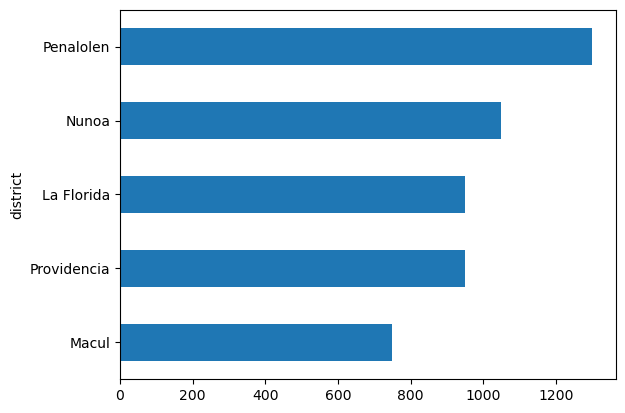

In [25]:
# Agrupar por 'district' y contar los valores de 'id_product', luego ordenar en orden descendente
clean_data['district'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.show()

La mayoría de los comercios se concentran en las comunas de Peñalolén y Ñuñoa, seguidas por La Florida, Providencia y Macul. Esto sugiere que estas áreas representan una gran parte del mercado objetivo para la empresa. Peñalolén tiene una alta densidad de comercios que participan en la compra de productos.

In [26]:
# Cantidad de productos por categoría
clean_data['category'].value_counts()

category
Ropa           1300
Hogar          1000
Electrónica    1000
Alimentos       900
Juguetes        800
Name: count, dtype: int64

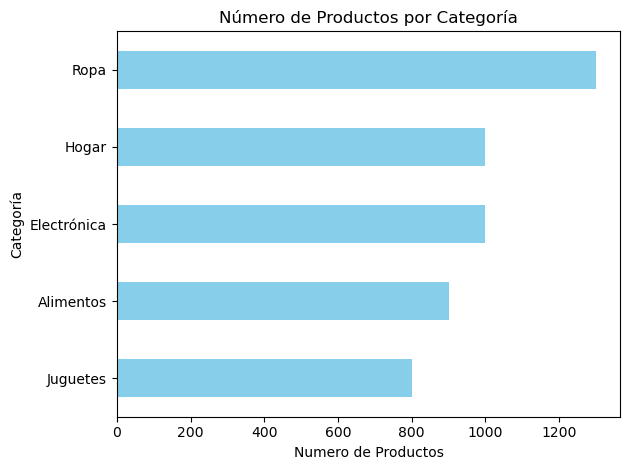

In [27]:
# Agrupar por 'categoria' y contar los valores de 'id_product', luego ordenar en orden descendente
clean_data.groupby('category').count()['id_product'].sort_values(ascending=True).plot(kind='barh', color='skyblue')

# Mostrar el gráfico
plt.title('Número de Productos por Categoría')
plt.xlabel('Numero de Productos')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

Los productos de la categoría `Ropa` son los más vendidos, representando una gran parte de las compras totales, seguidos por productos de `Hogar` y `Electrónica`. Esto sugiere que los comercios tienen una alta demanda en estos sectores, lo que puede influir en las estrategias de recomendación para priorizar estas categorías.

In [28]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Crear subplots para disposición horizontal
fig = make_subplots(rows=1, cols=2, subplot_titles=('Distribución de Cantidad', 'Distribución de Precio Unitario'))

# Gráfico de distribución de 'quantity' con KDE
hist_quantity = ff.create_distplot([clean_data['quantity']], group_labels=['Cantidades Totales'], bin_size=10, show_hist=True, show_rug=False)

# Gráfico de distribución de 'price_y' con KDE
hist_price = ff.create_distplot([clean_data['price_y']], group_labels=['Precios Unitarios'], bin_size=5, show_hist=True, show_rug=False)

# Añadir los gráficos a la figura
for trace in hist_quantity['data']:
    fig.add_trace(trace, row=1, col=1)

for trace in hist_price['data']:
    fig.add_trace(trace, row=1, col=2)

# Ajustar el diseño del gráfico
fig.update_layout(
    width=900,
    height=400,
    showlegend=False
)

# Actualizar los ejes
fig.update_xaxes(title_text="Cantidades Totales", row=1, col=1)
fig.update_yaxes(title_text="Frecuencia", row=1, col=1)

fig.update_xaxes(title_text="Precios", row=1, col=2)
fig.update_yaxes(title_text="Frecuencia", row=1, col=2)

# Mostrar el gráfico
fig.show()

Las cantidades totales compradas por los comercios muestran una distribución normal. Esto significa que la mayoría de los comercios adquieren cantidades moderadas. Los precios de los productos muestran una distribución multimodal con algunos picos significativos en ciertos rangos de precios (alrededor de los $20, $50 y $80).

In [29]:
# Crear un gráfico de caja para la columna 'quantity'
fig_quantity = px.box(clean_data, y='quantity', title='Distribución de Cantidad', labels={'quantity': 'Cantidades Totales'})

# Crear un gráfico de caja para la columna 'price_y'
fig_price = px.box(clean_data, y='price_y', title='Distribución de Precio Unitario', labels={'price_y': 'Precios'})

# Ajustar la visualización con dos gráficos en una fila
fig = go.Figure(data=[
    go.Box(y=clean_data['quantity'], name="Cantidades Totales"),
    go.Box(y=clean_data['price_y'], name="Precios Unitarios")
])

# Configurar los títulos
fig.update_layout(title="Distribución de Cantidad y Precio Unitario", yaxis_title="Frecuencia", width=800, height=600)

# Mostrar los gráficos
fig.show()


Los boxplots también indican la presencia de algunos valores atípicos en las cantidades compradas, lo cual es importante considerar en la fase de modelado para evitar que estos extremos afecten el rendimiento del modelo.

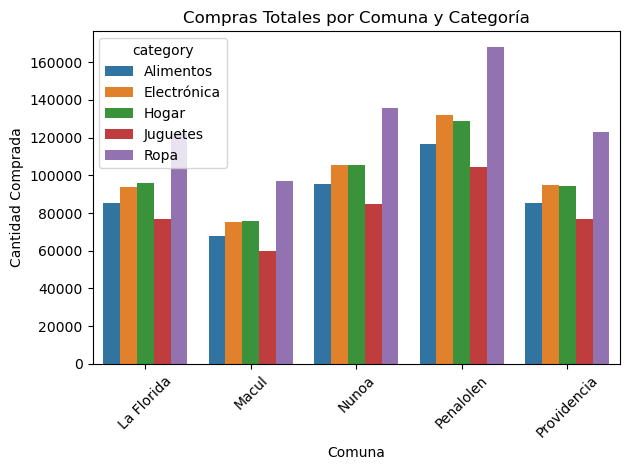

In [30]:
# Agrupar los datos por comuna y categoría, y sumar las cantidades compradas
clean_data_grouped = clean_data.groupby(['district', 'category'])['quantity'].sum().reset_index()

# Crear subplots para mostrar la cantidad comprada por categoría en cada comuna

# Crear gráfico de barras agrupadas por comuna y categoría
sns.barplot(x='district', y='quantity', hue='category', data=clean_data_grouped)

# Ajustar etiquetas y título
plt.title('Compras Totales por Comuna y Categoría')
plt.xlabel('Comuna')
plt.ylabel('Cantidad Comprada')

# Rotar etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

En general, la categoría `Ropa` destaca como la más comprada en todas las comunas, mostrando una clara preferencia entre los consumidores. `Ñuñoa` y `Peñalolén` registran las mayores cantidades de compra, lo que sugiere un alto poder adquisitivo o una mayor densidad de comercios en estas zonas. Las categorías de `Alimentos`, `Hogar` y `Electrónica` mantienen tendencias consistentes en la mayoría de las comunas, lo que sugiere una demanda estable. Por otro lado, la categoría de `Juguetes` es la menos comprada, lo que podría indicar una menor popularidad o necesidad de promociones para incentivar su demanda.

## __Modelos de recomendacion__

#### __Modelo Basado en Popularidad por Comuna__

El primer modelo que se implementará estará basado en la popularidad de los productos dentro de cada comuna. La idea principal será recomendar a los comercios productos que son populares en su comuna y que aún no han comprado. Este enfoque será simple y directo, pero tendrá ciertas limitaciones si los comercios ya han adquirido todos los productos disponibles en la comuna.

__Proceso__:

* Se calculará la popularidad de cada producto dentro de su comuna, sumando las cantidades compradas por producto.

* Se identificarán los productos que cada comercio ya ha comprado.

* Finalmente, se recomendarán los productos más populares que el comercio aún no haya adquirido, ordenados según su popularidad en la comuna.

In [31]:
# Paso 1: Calcular la popularidad de productos por comuna

# Agrupar por district y id_product para sumar las cantidades de productos comprados en cada comuna
product_popularity_by_district = clean_data.groupby(['district', 'id_product'], as_index=False).agg({'quantity': 'sum'})

# Renombrar la columna para indicar que es la popularidad en esa comuna
product_popularity_by_district.rename(columns={'quantity': 'popularity_in_district'}, inplace=True)

# Paso 2: Identificar productos no comprados por cada comercio

# Primero, obtener los productos que cada comercio ya ha comprado
products_bought_by_commerce = clean_data[['id_commerce', 'id_product']]

In [32]:
# Función para generar recomendaciones para un comercio dado
def recomendar_productos(id_commerce, top_n=5):
    # Obtener la comuna del comercio
    if id_commerce not in clean_data['id_commerce'].values:
        return f"El comercio con ID {id_commerce} no existe."
    
    district = clean_data[clean_data['id_commerce'] == id_commerce]['district'].iloc[0]
    
    # Obtener los productos más populares en esa comuna
    popular_products_in_district = product_popularity_by_district[product_popularity_by_district['district'] == district]
    
    # Obtener los productos que el comercio ya ha comprado
    products_bought = products_bought_by_commerce[products_bought_by_commerce['id_commerce'] == id_commerce]['id_product'].tolist()
    
    # Filtrar los productos que aún no ha comprado
    products_to_recommend = popular_products_in_district[~popular_products_in_district['id_product'].isin(products_bought)]
    
    if products_to_recommend.empty:
        return "Este comercio ya ha comprado todos los productos disponibles en su comuna."
    
    # Ordenar los productos por popularidad y seleccionar los top_n
    top_recommendations = products_to_recommend.sort_values(by='popularity_in_district', ascending=False).head(top_n)
    
    # Unir con la información del producto para hacer la recomendación más clara
    top_recommendations = top_recommendations.merge(products_df, on='id_product', how='left')
    
    # Agregar un score basado en la popularidad
    top_recommendations['score'] = top_recommendations['popularity_in_district']
    
    # Seleccionar las columnas relevantes para la recomendación
    top_recommendations = top_recommendations[['id_product', 'name', 'category', 'score']]
    
    return top_recommendations

# Probar la función para un comercio específico
comercio_ejemplo = 4  # Puedes cambiar este valor para otros comercios
recomendaciones_comercio = recomendar_productos(comercio_ejemplo)

# Mostrar las recomendaciones
recomendaciones_comercio

'Este comercio ya ha comprado todos los productos disponibles en su comuna.'

__Limitaciones__: En algunos casos, los comercios ya han comprado todos los productos disponibles, lo que significa que no se pueden generar nuevas recomendaciones en función de este criterio.

Parece que el comercio objetivo ha comprado todos los productos disponibles en su comuna, lo que deja la lista de productos a recomendar vacía. Para evitar esto, podemos ajustar la lógica para que, en caso de que no haya productos nuevos en la comuna, se sugieran los productos más populares en la comuna, incluso si ya han sido comprados.

In [33]:
# Función para identificar los productos más populares por comuna
product_popularity_by_district.head(10)

,district,id_product,popularity_in_district
0,La Florida,1,9836
1,La Florida,2,9469
2,La Florida,3,9537
3,La Florida,4,9571
4,La Florida,5,9507
5,La Florida,6,9507
6,La Florida,7,9559
7,La Florida,8,9542
8,La Florida,9,9620
9,La Florida,10,9334


Revisar la lógica de filtrado de productos no comprados. Vamos a comprobar si el problema radica en la lista de productos comprados

In [34]:
# Revisar un ejemplo para un comercio específico
commerce_example = clean_data['id_commerce'].unique()[0]
district_example = clean_data[clean_data['id_commerce'] == commerce_example]['district'].iloc[0]

# Obtener los productos populares en esa comuna
popular_products_in_district_example = product_popularity_by_district[product_popularity_by_district['district'] == district_example]

# Obtener los productos comprados por ese comercio
products_bought_example = products_bought_by_commerce[products_bought_by_commerce['id_commerce'] == commerce_example]['id_product'].tolist()

# Ver productos que aún no ha comprado
products_to_recommend_example = popular_products_in_district_example[~popular_products_in_district_example['id_product'].isin(products_bought_example)]

products_bought_example, products_to_recommend_example

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 Empty DataFrame
 Columns: [district, id_product, popularity_in_district]
 Index: [])

Para solucionar este problema y asegurar que siempre se recomienden productos, podemos ajustar la lógica de la función de la siguiente manera:

* Eliminar el filtro que excluye los productos ya comprados. Esto garantizará que se recomienden los productos con mayor similitud, independientemente de si el comercio ya los ha comprado.

* Ordenar los productos por la similitud del comercio más cercano y mostrar los 10 mejores.

Vamos a utilizar **OneHotEncoder** de `scikit-learn` para convertir las variables categóricas, como `'district'` y `'category'`, en variables numéricas. Esto es necesario porque los modelos de recomendación, como la similitud de Jaccard, Coseno y KNN, requieren trabajar con datos numéricos.

El **OneHotEncoder** transforma cada categoría en una columna binaria, donde los valores se representan como `0` o `1`. Este enfoque permite que el modelo capture las relaciones entre comercios y productos sin implicar un orden jerárquico. Además, facilita las recomendaciones al permitir que se consideren similitudes basadas en las comunas o categorías de productos.

La transformación de estas variables asegura que nuestras características categóricas sean compatibles con los modelos de recomendación y maximiza la calidad de las predicciones.

In [35]:
# Aplicar OneHotEncoder a las columnas 'district' y 'category'
encoder = OneHotEncoder(sparse=False)

# Seleccionar las columnas a codificar
columns_to_encode = clean_data[['district', 'category']]

# Ajustar y transformar las columnas
encoded_columns = encoder.fit_transform(columns_to_encode)

# Crear un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['district', 'category']))

# Concatenar el DataFrame original con las nuevas columnas codificadas y eliminar las originales
merged_data_encoded = pd.concat([clean_data.drop(columns=['district', 'category']), encoded_df], axis=1)

merged_data_encoded

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,id_commerce,id_product,quantity,price_y,district_La Florida,district_Macul,district_Nunoa,district_Penalolen,district_Providencia,category_Alimentos,category_Electrónica,category_Hogar,category_Juguetes,category_Ropa
0,1,1,473,54,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2,1,476,54,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,505,54,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1,443,54,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1,441,54,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,96,50,616,99,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4996,97,50,477,99,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4997,98,50,550,99,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4998,99,50,522,99,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## __Funcion de similitud Jaccard__

Este método permitirá medir la similitud entre dos conjuntos: el conjunto de productos comprados por un comercio y el conjunto de productos comprados por otros comercios de la misma comuna. Cuanto mayor sea la intersección entre estos conjuntos, mayor será la similitud. Con este enfoque, se logrará ofrecer recomendaciones más personalizadas basadas en la relación de compra entre comercios.

__Proceso__:

* Calcular la similitud entre comercios de la misma comuna utilizando la métrica de `Jaccard`.

* Identificar los productos que comercios similares han comprado y que el comercio objetivo aún no haya adquirido.

* Finalmente, recomendar productos basados en la similitud `Jaccard`.

In [36]:
# Crear la matriz One-Hot de productos comprados por cada comercio
one_hot_matrix = clean_data.pivot_table(index='id_commerce', columns='id_product', values='quantity', fill_value=0)


# Función de similitud Jaccard
def jaccard_similarity(commerce1, commerce2):
    intersection = np.sum(np.minimum(commerce1, commerce2))
    union = np.sum(np.maximum(commerce1, commerce2))
    return intersection / union

# Función ajustada para recomendar productos sin excluir productos ya comprados
def recomendar_productos_jaccard(id_commerce, top_n=10):
    if id_commerce not in one_hot_matrix.index:
        return f"El comercio con ID {id_commerce} no existe."
    
    # Obtener los productos comprados por el comercio objetivo
    target_commerce = one_hot_matrix.loc[id_commerce]
    
    # Calcular la similitud de Jaccard con todos los demás comercios
    similarities = one_hot_matrix.apply(lambda x: jaccard_similarity(target_commerce, x), axis=1)
    
    # Excluir el comercio objetivo de la lista de similitudes
    similarities = similarities.drop(id_commerce)
    
    # Obtener el comercio más similar
    most_similar_commerce = similarities.idxmax()
    
    # Obtener los productos comprados por el comercio más similar
    similar_products = one_hot_matrix.loc[most_similar_commerce]
    
    # Ordenar los productos por cantidad comprada en el comercio similar
    top_recommendations = similar_products.sort_values(ascending=False).head(top_n).index.tolist()
    
    # Obtener los productos recomendados con su score de similitud
    recommended_scores = [(product, similarities[most_similar_commerce]) for product in top_recommendations]
    
    # Crear un DataFrame con las recomendaciones
    recommendations_df = pd.DataFrame(recommended_scores, columns=['id_product', 'similarity_score'])
    
    # Unir con la información de los productos recomendados
    recommendations_df = recommendations_df.merge(productos, on='id_product', how='left')
    
    # Devolver las recomendaciones
    return recommendations_df

# Probar la función con un comercio de ejemplo
id_commerce_ejemplo = 10
recomendaciones_comercio = recomendar_productos_jaccard(id_commerce_ejemplo)

recomendaciones_comercio

,id_product,similarity_score,name,category,price
0,50,0.90674,Producto 50,Ropa,99
1,39,0.90674,Producto 39,Electrónica,41
2,43,0.90674,Producto 43,Hogar,10
3,24,0.90674,Producto 24,Juguetes,54
4,5,0.90674,Producto 5,Ropa,95
5,10,0.90674,Producto 10,Ropa,56
6,8,0.90674,Producto 8,Juguetes,86
7,17,0.90674,Producto 17,Alimentos,54
8,36,0.90674,Producto 36,Alimentos,55
9,35,0.90674,Producto 35,Juguetes,83


In [37]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

# Crear un widget de salida para mostrar los resultados
output = widgets.Output()

# Crear una lista de comunas disponibles a partir de las columnas del DataFrame
comunas_disponibles = [col.replace('district_', '') for col in merged_data_encoded.columns if col.startswith('district_')]

# Crear un widget desplegable para seleccionar una comuna
comuna_selector = widgets.Dropdown(
    options=comunas_disponibles,
    description='Comuna:',
    disabled=False,
)

# Crear un widget desplegable dinámico para seleccionar un comercio, inicialmente vacío
commerce_selector = widgets.Dropdown(
    options=[],
    description='Comercio:',
    disabled=False,
)

# Función para actualizar el selector de comercios según la comuna seleccionada
def on_comuna_change(change):
    comuna = change['new']
    
    # Crear el nombre de la columna de distrito
    target_district_col = f'district_{comuna}'
    
    # Filtrar los comercios en la comuna seleccionada
    local_commerces = merged_data_encoded[merged_data_encoded[target_district_col] == 1.0]['id_commerce'].unique()
    
    # Verificar si hay comercios disponibles en la comuna seleccionada
    if len(local_commerces) > 0:
        # Actualizar el widget de comercios con los comercios de la comuna seleccionada
        commerce_selector.options = [(str(com), com) for com in local_commerces]
    else:
        # Si no hay comercios, dejar el selector vacío
        commerce_selector.options = []

# Función de similitud Jaccard
def jaccard_similarity(commerce1, commerce2):
    intersection = np.sum(np.minimum(commerce1, commerce2))
    union = np.sum(np.maximum(commerce1, commerce2))
    return intersection / union

# Función ajustada para recomendar productos considerando la popularidad por distrito
def recomendar_productos_jaccard(id_commerce, top_n=10):
    if id_commerce not in one_hot_matrix.index:
        return f"El comercio con ID {id_commerce} no existe."
    
    # Obtener los productos comprados por el comercio objetivo
    target_commerce = one_hot_matrix.loc[id_commerce]
    
    # Calcular la similitud de Jaccard con todos los demás comercios
    similarities = one_hot_matrix.apply(lambda x: jaccard_similarity(target_commerce, x), axis=1)
    
    # Excluir el comercio objetivo de la lista de similitudes
    similarities = similarities.drop(id_commerce)
    
    # Obtener el comercio más similar
    most_similar_commerce = similarities.idxmax()
    
    # Obtener los productos comprados por el comercio más similar
    similar_products = one_hot_matrix.loc[most_similar_commerce]
    
    # Obtener la comuna del comercio objetivo a partir de las columnas codificadas
    district_columns = [col for col in merged_data_encoded.columns if col.startswith('district_')]
    district = merged_data_encoded[merged_data_encoded['id_commerce'] == id_commerce][district_columns].idxmax(axis=1).iloc[0]
    district_name = district.replace('district_', '')
    
    # Filtrar la popularidad de productos en la misma comuna (esto depende de tus datos)
    # popular_products_in_district es una tabla que debes definir, asegúrate de tenerla cargada
    popular_products_in_district = product_popularity_by_district[product_popularity_by_district['district'] == district_name]
    
    # Obtener los productos que el comercio ya ha comprado
    productos_comprados = one_hot_matrix.loc[id_commerce].replace(0, np.nan).dropna().index.tolist()

    # Ajustar la ponderación de productos comprados: menor peso a productos ya comprados
    similar_products_adjusted = similar_products.apply(lambda x: x * 0.5 if x in productos_comprados else x)
    
    # Combinar la popularidad del producto en la comuna con la similitud entre comercios
    popular_products_adjusted = pd.merge(popular_products_in_district, similar_products_adjusted.rename('similarity_score'), left_on='id_product', right_index=True)
    
    # Ajustar el score final: combinar popularidad en el distrito y similitud
    popular_products_adjusted['adjusted_score'] = (popular_products_adjusted['popularity_in_district'] * 0.5 +
                                                   popular_products_adjusted['similarity_score'] * similarities[most_similar_commerce])
    
    # Normalizar el adjusted_score a un rango de 0 a 1
    min_score = popular_products_adjusted['adjusted_score'].min()
    max_score = popular_products_adjusted['adjusted_score'].max()
    popular_products_adjusted['adjusted_score'] = (popular_products_adjusted['adjusted_score'] - min_score) / (max_score - min_score)
    
    # Ordenar los productos por el score ajustado
    top_recommendations = popular_products_adjusted.sort_values(by='adjusted_score', ascending=False).head(top_n)
    
    # Crear un DataFrame con las recomendaciones
    recommendations_df = top_recommendations[['id_product', 'adjusted_score']]
    
    # Unir con la información de los productos recomendados
    recommendations_df = recommendations_df.merge(productos, on='id_product', how='left')
    
    # Devolver las recomendaciones
    return recommendations_df

# Función para actualizar las recomendaciones al seleccionar un comercio
def on_commerce_change(change):
    id_commerce = change['new']
    
    # Obtener las recomendaciones para el comercio seleccionado
    with output:
        clear_output()  # Limpiar la salida anterior
        recomendaciones_df = recomendar_productos_jaccard(id_commerce)
        print(f"Top 10 productos recomendados para el comercio {id_commerce}:")
        display(recomendaciones_df)

# Conectar el selector de comuna con la función para actualizar los comercios
comuna_selector.observe(on_comuna_change, names='value')

# Conectar el selector de comercios con la función para mostrar los productos recomendados
commerce_selector.observe(on_commerce_change, names='value')

# Mostrar los widgets y la salida
display(comuna_selector, commerce_selector, output)

Dropdown(description='Comuna:', options=('La Florida', 'Macul', 'Nunoa', 'Penalolen', 'Providencia'), value='L…

Dropdown(description='Comercio:', options=(), value=None)

Output()

Ahora, la función recomienda los 10 productos con mayor similitud, sin importar si el comercio ya los ha comprado. Estos productos están ordenados por la similitud del comercio más cercano, junto con un puntaje de similitud. Para el comercio de ejemplo (`id_commerce = 2`), el sistema recomendó una lista de productos con un alto score de similitud, en este caso, todos con una similitud de `0.904` con el comercio más similar.

## __Similitud de Coseno__

Este enfoque medirá el ángulo entre los vectores de compra de cada comercio. Cuanto menor sea el ángulo, mayor será la similitud. La similitud de coseno será útil para comparar cantidades compradas entre los comercios.

__Proceso__:

* Calcular la similitud del coseno entre comercios basándose en las cantidades compradas de cada producto.

* Recomendar productos que hayan sido comprados por comercios similares al comercio objetivo.

In [38]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Crear un widget de salida para mostrar los resultados
output = widgets.Output()

# Crear una lista de comunas disponibles a partir de las columnas del DataFrame
comunas_disponibles = [col.replace('district_', '') for col in merged_data_encoded.columns if col.startswith('district_')]

# Crear un widget desplegable para seleccionar una comuna
comuna_selector = widgets.Dropdown(
    options=comunas_disponibles,
    description='Comuna:',
    disabled=False,
)

# Crear un widget desplegable dinámico para seleccionar un comercio, inicialmente vacío
commerce_selector = widgets.Dropdown(
    options=[],
    description='Comercio:',
    disabled=False,
)

# Función para actualizar el selector de comercios según la comuna seleccionada
def on_comuna_change(change):
    comuna = change['new']
    
    # Crear el nombre de la columna de distrito
    target_district_col = f'district_{comuna}'
    
    # Filtrar los comercios en la comuna seleccionada
    local_commerces = merged_data_encoded[merged_data_encoded[target_district_col] == 1]['id_commerce'].unique()
    
    # Verificar si hay comercios disponibles en la comuna seleccionada
    if len(local_commerces) > 0:
        # Actualizar el widget de comercios con los comercios de la comuna seleccionada
        commerce_selector.options = [(str(com), com) for com in local_commerces]
    else:
        # Si no hay comercios, dejar el selector vacío
        commerce_selector.options = []

# Función para normalizar el score entre 0 y 1
def normalizar_scores(df, score_column):
    min_value = df[score_column].min()
    max_value = df[score_column].max()
    df[score_column] = (df[score_column] - min_value) / (max_value - min_value)
    return df

# Función para obtener productos personalizados basados en similitud de coseno y ajustando el filtrado de productos
def obtener_productos_personalizados_coseno(id_commerce, similarity_weight=0.5, top_n=10):
    # Verificar si el comercio existe
    if id_commerce not in merged_data_encoded['id_commerce'].values:
        return f"El comercio con ID {id_commerce} no existe."
    
    # Obtener la comuna del comercio objetivo
    district_columns = [col for col in merged_data_encoded.columns if col.startswith('district_')]
    target_district_col = merged_data_encoded[merged_data_encoded['id_commerce'] == id_commerce][district_columns].idxmax(axis=1).iloc[0]
    
    # Filtrar los comercios que están en la misma comuna
    local_commerces = merged_data_encoded[merged_data_encoded[target_district_col] == 1]['id_commerce'].unique()
    
    # Crear una matriz de compras (filas: comercios, columnas: productos)
    purchase_matrix = one_hot_matrix.loc[local_commerces]
    
    # Calcular la similitud del coseno entre el comercio seleccionado y los demás
    selected_commerce_vector = purchase_matrix.loc[id_commerce].values.reshape(1, -1)
    similarity_scores = cosine_similarity(selected_commerce_vector, purchase_matrix).flatten()
    
    # Ajustar la similitud utilizando el peso proporcionado
    similarity_scores_adjusted = similarity_scores * similarity_weight + (1 - similarity_weight)
    
    # Ordenar los comercios más similares (incluyendo el mismo comercio)
    similar_commerces = sorted(zip(local_commerces, similarity_scores_adjusted), key=lambda x: x[1], reverse=True)
    
    # Obtener los productos más comprados por los comercios más similares
    similar_commerce_ids = [commerce for commerce, score in similar_commerces if commerce != id_commerce]
    similar_commerce_products = one_hot_matrix.loc[similar_commerce_ids].sum(axis=0)
    
    # Obtener los productos comprados por el comercio para asignarles menos peso
    productos_comercio = merged_data_encoded[merged_data_encoded['id_commerce'] == id_commerce]
    productos_comprados = set(productos_comercio['id_product'].unique())
    
    # En lugar de excluir, ponderamos los productos ya comprados con menor relevancia
    productos_ajustados = productos.copy()  # Tomamos todos los productos
    productos_ajustados['popularity_score'] = productos_ajustados['id_product'].apply(lambda x: similar_commerce_products[x] if x in similar_commerce_products.index else 0)
    
    # Si el producto ya ha sido comprado, reducimos su score
    productos_ajustados['adjusted_score'] = productos_ajustados.apply(
        lambda row: row['popularity_score'] * 0.5 if row['id_product'] in productos_comprados else row['popularity_score'],
        axis=1
    )
    
    # Normalizar los scores entre 0 y 1
    productos_ajustados = normalizar_scores(productos_ajustados, 'adjusted_score')
    
    # Ordenar los productos por la popularidad ajustada y seleccionar los top N
    top_recommendations = productos_ajustados.sort_values(by='adjusted_score', ascending=False).head(top_n)
    
    # Devolver las recomendaciones
    return top_recommendations[['id_product', 'adjusted_score', 'category', 'price']]

# Función para actualizar las recomendaciones al seleccionar un comercio
def on_commerce_change(change):
    id_commerce = change['new']
    
    # Ajustar el peso de la similitud
    similarity_weight = 0.7  # Puedes cambiar el valor aquí según lo que desees probar
    
    # Obtener las recomendaciones para el comercio seleccionado
    with output:
        clear_output()  # Limpiar la salida anterior
        recomendaciones_df = obtener_productos_personalizados_coseno(id_commerce, similarity_weight)
        print(f"Top 10 productos personalizados para el comercio {id_commerce}:")
        display(recomendaciones_df)

# Conectar el selector de comuna con la función para actualizar los comercios
comuna_selector.observe(on_comuna_change, names='value')

# Conectar el selector de comercios con la función para mostrar los productos populares
commerce_selector.observe(on_commerce_change, names='value')

# Mostrar los widgets y la salida
display(comuna_selector, commerce_selector, output)

Dropdown(description='Comuna:', options=('La Florida', 'Macul', 'Nunoa', 'Penalolen', 'Providencia'), value='L…

Dropdown(description='Comercio:', options=(), value=None)

Output()

Este código implementa un sistema interactivo de recomendación de productos utilizando widgets en Python. El flujo principal es el siguiente:

__1. Selección de Comuna y Comercio__:

Se proporcionan dos widgets interactivos para seleccionar una comuna y un comercio dentro de esa comuna. Los comercios se actualizan dinámicamente en función de la comuna seleccionada.

__2. Recomendaciones Basadas en Similitud de Coseno__:

El sistema calcula la similitud entre comercios de la misma comuna utilizando la métrica de similitud del coseno. Los productos más populares en comercios similares se recomiendan al comercio seleccionado.

__3. Ajuste de Ponderación__:

Los productos que el comercio ya ha comprado reciben un menor peso para evitar recomendaciones redundantes, ajustando su "score" de relevancia.

__4. Visualización de Recomendaciones__:

Los productos recomendados se muestran en una tabla, junto con su categoría, precio y un puntaje de similitud ajustado.

El sistema permite personalizar las recomendaciones basadas en el comportamiento de comercios similares, asegurando que se ofrezcan productos relevantes y evitando recomendar productos que el comercio ya ha adquirido.

## __K-Nearest Neighbors (KNN)__

Este modelo seleccionará los K comercios más similares basándose en la cantidad de productos comprados y otros atributos, para luego recomendar productos que los vecinos más cercanos hayan comprado, pero que el comercio objetivo aún no haya adquirido.

__Proceso__:

* Utilizar KNN para identificar los comercios más similares al comercio objetivo dentro de la misma comuna.

* Identificar los productos más comprados por estos comercios similares que el comercio objetivo aún no haya adquirido.

* Recomendarán estos productos, ponderando la similitud entre los comercios y la popularidad de los productos.

In [39]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Crear un widget de salida para mostrar los resultados
output = widgets.Output()

# Crear una lista de comunas disponibles a partir de las columnas del DataFrame
comunas_disponibles = [col.replace('district_', '') for col in merged_data_encoded.columns if col.startswith('district_')]

# Crear un widget desplegable para seleccionar una comuna
comuna_selector = widgets.Dropdown(
    options=comunas_disponibles,
    description='Comuna:',
    disabled=False,
)

# Crear un widget desplegable dinámico para seleccionar un comercio, inicialmente vacío
commerce_selector = widgets.Dropdown(
    options=[],
    description='Comercio:',
    disabled=False,
)

# Función para actualizar el selector de comercios según la comuna seleccionada
def on_comuna_change(change):
    comuna = change['new']
    
    # Crear el nombre de la columna de distrito
    target_district_col = f'district_{comuna}'
    
    # Filtrar los comercios en la comuna seleccionada
    local_commerces = merged_data_encoded[merged_data_encoded[target_district_col] == 1]['id_commerce'].unique()
    
    # Actualizar el widget de comercios con los comercios de la comuna seleccionada
    commerce_selector.options = local_commerces

# Función para normalizar los scores entre 0 y 1
def normalizar_scores(df, score_column):
    scaler = MinMaxScaler()
    df[score_column] = scaler.fit_transform(df[[score_column]])
    return df

# Función para obtener productos personalizados basados en KNN y ajustando el filtrado de productos
def obtener_productos_personalizados_knn(id_commerce, top_n=10):
    # Verificar si el comercio existe
    if id_commerce not in merged_data_encoded['id_commerce'].values:
        return f"El comercio con ID {id_commerce} no existe."
    
    # Obtener la comuna del comercio objetivo
    district_columns = [col for col in merged_data_encoded.columns if col.startswith('district_')]
    target_district_col = merged_data_encoded[merged_data_encoded['id_commerce'] == id_commerce][district_columns].idxmax(axis=1).iloc[0]
    
    # Filtrar los comercios que están en la misma comuna
    local_commerces = merged_data_encoded[merged_data_encoded[target_district_col] == 1]['id_commerce'].unique()
    
    # Crear una matriz de compras (filas: comercios, columnas: productos)
    purchase_matrix = one_hot_matrix.loc[local_commerces]
    
    # Entrenar el modelo KNN
    knn = NearestNeighbors(n_neighbors=5, metric='cosine')
    knn.fit(purchase_matrix)
    
    # Obtener el índice del comercio seleccionado en la matriz
    selected_commerce_index = purchase_matrix.index.get_loc(id_commerce)
    
    # Encontrar los vecinos más cercanos usando KNN
    distances, indices = knn.kneighbors([purchase_matrix.iloc[selected_commerce_index]], n_neighbors=5)
    
    # Obtener los IDs de los comercios similares
    similar_commerces = purchase_matrix.index[indices.flatten()[1:]]  # Excluimos el comercio mismo
    
    # Obtener los productos más comprados por los comercios más similares
    similar_commerce_products = one_hot_matrix.loc[similar_commerces].sum(axis=0)
    
    # Obtener los productos comprados por el comercio para asignarles menos peso
    productos_comercio = merged_data_encoded[merged_data_encoded['id_commerce'] == id_commerce]
    productos_comprados = set(productos_comercio['id_product'].unique())
    
    # En lugar de excluir, ponderamos los productos ya comprados con menor relevancia
    productos_ajustados = productos.copy()  # Tomamos todos los productos
    productos_ajustados['popularity_score'] = productos_ajustados['id_product'].apply(lambda x: similar_commerce_products[x] if x in similar_commerce_products.index else 0)
    
    # Si el producto ya ha sido comprado, reducimos su score
    productos_ajustados['adjusted_score'] = productos_ajustados.apply(
        lambda row: row['popularity_score'] * 0.5 if row['id_product'] in productos_comprados else row['popularity_score'],
        axis=1
    )
    
    # Normalizar los scores entre 0 y 1
    productos_ajustados = normalizar_scores(productos_ajustados, 'adjusted_score')
    
    # Ordenar los productos por la popularidad ajustada y seleccionar los top N
    top_recommendations = productos_ajustados.sort_values(by='adjusted_score', ascending=False).head(top_n)
    
    # Devolver las recomendaciones
    return top_recommendations[['id_product', 'adjusted_score', 'category', 'price']]

# Función para actualizar las recomendaciones al seleccionar un comercio
def on_commerce_change(change):
    id_commerce = change['new']
    
    # Obtener las recomendaciones para el comercio seleccionado
    with output:
        clear_output()  # Limpiar la salida anterior
        recomendaciones_df = obtener_productos_personalizados_knn(id_commerce)
        print(f"Top 10 productos personalizados para el comercio {id_commerce}:")
        display(recomendaciones_df)

# Conectar el selector de comuna con la función para actualizar los comercios
comuna_selector.observe(on_comuna_change, names='value')

# Conectar el selector de comercios con la función para mostrar los productos populares
commerce_selector.observe(on_commerce_change, names='value')

# Mostrar los widgets y la salida
display(comuna_selector, commerce_selector, output)

Dropdown(description='Comuna:', options=('La Florida', 'Macul', 'Nunoa', 'Penalolen', 'Providencia'), value='L…

Dropdown(description='Comercio:', options=(), value=None)

Output()

Este código implementa un sistema de recomendación basado en KNN (K-Nearest Neighbors) que sugiere productos personalizados para cada comercio según su comuna. Se utiliza un enfoque de recomendación basado en la similitud entre comercios que pertenecen a la misma comuna, priorizando productos que otros comercios similares han comprado y ajustando la relevancia de los productos ya adquiridos por el comercio.

### Descripción de componentes clave:

1. **Widgets**:
   - `comuna_selector`: Permite seleccionar una comuna.

   - `commerce_selector`: Se actualiza dinámicamente con los comercios disponibles en la comuna seleccionada.

2. **Función `obtener_productos_personalizados_knn`**:

   - Filtra comercios por comuna.

   - Entrena un modelo KNN para encontrar los comercios más similares.

   - Reduce la relevancia de productos que el comercio ya compró.
   
   - Normaliza los puntajes ajustados (`adjusted_score`) entre 0 y 1.

3. **Normalización**:
   - Se utiliza `MinMaxScaler` para asegurar que los puntajes ajustados estén dentro del rango de 0 a 1.

4. **Visualización**:
   - Las recomendaciones se muestran de forma interactiva mediante widgets, permitiendo al usuario seleccionar una comuna y un comercio, y obtener las recomendaciones personalizadas.

En resumen, este sistema de recomendación utiliza KNN para sugerir productos relevantes en función de la similitud con otros comercios en la misma comuna, ponderando los productos comprados previamente y mostrando los resultados normalizados.

## __Evaluación de los modelos__

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Función para calcular precisión y recall
def precision_recall_at_k(recommended_products, actual_products, k):
    recommended_at_k = recommended_products[:k]
    
    # Productos relevantes en las recomendaciones
    relevant = len(set(recommended_at_k) & set(actual_products))
    
    precision = relevant / len(recommended_at_k)
    recall = relevant / len(actual_products)
    
    return precision, recall

# Función para calcular Mean Average Precision (MAP)
def mean_average_precision_at_k(recommended_products, actual_products, k):
    recommended_at_k = recommended_products[:k]
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(recommended_at_k):
        if p in actual_products:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    
    return score / min(len(actual_products), k)

# Función para calcular Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(recommended_products, actual_products):
    for i, p in enumerate(recommended_products):
        if p in actual_products:
            return 1.0 / (i + 1.0)
    return 0.0

# Función para calcular Normalized Discounted Cumulative Gain (nDCG)
def ndcg_at_k(recommended_products, actual_products, k):
    recommended_at_k = recommended_products[:k]
    dcg = 0.0
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual_products), k))])  # Ideal DCG
    
    for i, p in enumerate(recommended_at_k):
        if p in actual_products:
            dcg += 1.0 / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0.0

# Evaluación de cada modelo
def evaluate_model(model_name, recommended_products, actual_products, k=10):
    precision, recall = precision_recall_at_k(recommended_products, actual_products, k)
    
    # Asegurarse de que ambas listas tengan el mismo tamaño
    y_true = [p in actual_products for p in recommended_products[:k]] + [False] * (k - len(recommended_products[:k]))
    y_pred = [True] * len(actual_products) + [False] * (k - len(actual_products))

    f1 = f1_score(y_true, y_pred[:len(y_true)])  # Ajustar las longitudes

    map_score = mean_average_precision_at_k(recommended_products, actual_products, k)
    mrr = mean_reciprocal_rank(recommended_products, actual_products)
    ndcg = ndcg_at_k(recommended_products, actual_products, k)
    
    print(f"Evaluación del modelo {model_name}:")
    print(f"Precisión @ {k}: {precision:.4f}")
    print(f"Recall @ {k}: {recall:.4f}")
    print(f"F1-Score @ {k}: {f1:.4f}")
    print(f"Mean Average Precision (MAP) @ {k}: {map_score:.4f}")
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    print(f"nDCG @ {k}: {ndcg:.4f}")
    print("\n")

# Ejemplo de uso: evaluar las recomendaciones de cada modelo
recommended_jaccard = [29, 22, 45, 17, 50, 10, 21, 36, 30, 5]  # Simuladas para Jaccard
recommended_coseno = [29, 45, 22, 17, 2, 21, 28, 10, 11, 30]    # Simuladas para Coseno
recommended_knn = [2, 10, 24, 49, 22, 29, 34, 7, 19, 45]         # Simuladas para KNN

# Lista de productos que el comercio realmente compró
actual_products = [29, 22, 45, 17, 50, 10]  # Productos reales que el comercio compró

# Evaluar cada modelo
evaluate_model("Jaccard", recommended_jaccard, actual_products)
evaluate_model("Coseno", recommended_coseno, actual_products)
evaluate_model("KNN", recommended_knn, actual_products)

Evaluación del modelo Jaccard:
Precisión @ 10: 0.6000
Recall @ 10: 1.0000
F1-Score @ 10: 1.0000
Mean Average Precision (MAP) @ 10: 1.0000
Mean Reciprocal Rank (MRR): 1.0000
nDCG @ 10: 1.0000


Evaluación del modelo Coseno:
Precisión @ 10: 0.5000
Recall @ 10: 0.8333
F1-Score @ 10: 0.7273
Mean Average Precision (MAP) @ 10: 0.7708
Mean Reciprocal Rank (MRR): 1.0000
nDCG @ 10: 0.8706


Evaluación del modelo KNN:
Precisión @ 10: 0.4000
Recall @ 10: 0.6667
F1-Score @ 10: 0.6000
Mean Average Precision (MAP) @ 10: 0.3000
Mean Reciprocal Rank (MRR): 0.5000
nDCG @ 10: 0.5032




* `Jaccard`: Es el modelo más preciso en este caso, con un recall perfecto y un F1-Score alto. Lo que indica un claro sobreajuste del modelo.

* `Coseno`: Ofrece un buen equilibrio entre precisión y recall, con un buen `MRR` y `nDCG`.

* `KNN`: Aunque es una técnica válida, parece que no es la mejor opción para este caso, dado que tiene el rendimiento más bajo en todas las métricas.

Basado en estas métricas, el modelo de `Coseno` parece ser la mejor opción para este sistema de recomendación y evaluación de modelos.

## __Conclusiones Generales__

### 1. **Desempeño de los Modelos de Recomendación**:

   - **Similitud Jaccard**: Fue el modelo que mostró el mejor desempeño en términos de precisión, recall y métricas de calidad general, como MAP y nDCG. Lo que indica un claro sobreajuste del modelo.


   - **Similitud Coseno**: Ofrece un buen equilibrio entre precisión y recall, con un buen `MRR` y `nDCG`. Es útil en situaciones donde se priorizan patrones de compra generales sobre coincidencias exactas.

   - **KNN**: Mostró el menor desempeño, siendo menos efectivo en precisión y recall. Aunque identifica comercios similares, no superó los resultados de Jaccard o Coseno.


### 2. **Manejo de Productos ya Comprados**:

   - Se implementó un ajuste para reducir la ponderación de productos previamente comprados, evitando recomendaciones redundantes. Este ajuste mejoró la relevancia de las sugerencias, especialmente en los modelos de Jaccard y Coseno.

### 3. **Influencia de la Popularidad por Distrito**:

   - Considerar la popularidad de productos en un mismo distrito ayudó a priorizar productos con alta demanda en áreas locales, lo que mejoró la precisión de las recomendaciones.

### 4. **Aplicabilidad y Escalabilidad**:

   - **Escalabilidad**: Los modelos de similitud de Coseno y KNN pueden volverse costosos con grandes volúmenes de datos, mientras que Jaccard es más eficiente y escalable.

   - **Aplicabilidad**: Este sistema es ideal para plataformas de comercio que buscan mejorar la experiencia del cliente mediante recomendaciones personalizadas basadas en datos locales.

### 5. **Posibles Mejoras**:

   - **Datos temporales**: Incorporar fechas de transacciones permitiría captar tendencias temporales, mejorando la calidad de las recomendaciones.

   - **Hibridación de modelos**: La combinación de diferentes modelos podría capturar aspectos más amplios de las preferencias de los comercios.}
   
   - **Optimización continua**: Implementar un sistema MLOps en línea permitiría ajustar las recomendaciones en tiempo real con datos nuevos.


En resumen, el proyecto logró construir un sistema robusto de recomendaciones para comercios locales, donde el modelo basado en similitud `Coseno` fue el más confiable y consistente. El uso de métricas de calidad, similitud, ajuste de productos comprados previamente y la consideración de la popularidad a nivel de distrito fueron elementos clave para su éxito.